## Read me
This script contains:

1. an IODE solver that gives an analytical expression for the amplitude a(t) from Prosperetti 1976
2. an analytical expression for the amplitude a(t) from Prosperetti 1981
3. Comparison between analytical and numerical amplitude for a single interface

## Packages and specificities for plot

In [1]:
#Import relevant packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.integrate import odeint
from scipy.integrate import quadrature
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import time

#Use Latex and serif font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Analytical A(t) from Prosperetti 1976 Eq.18
Generates analytical expression for the amplitude a(t) for the case, where one fluid has no density and viscosity. It corresponds to the equation 18 from Prosperetti 1976 paper and to the sub-case of equation 20 from Prosperetti's 1981 paper, when both density and visocity of one of the fluids' is 0. 

In [ ]:
##Functions

#1.Defines an ODE function without integral
def model0_0(a,t):
    dadt = a[1]
    d2adt2 = -16 * (np.pi**2 / np.sqrt(Ga)) * a[1] - 2 * np.pi * a[0]
    return [dadt,d2adt2]

#2.Defines the ODE with integral
def model(t,a,guess):
    #The time variable that the model receives could be messing up the integral term 
    interpolator = interp1d(guess[:,0], guess[:,1], kind='linear') 
    integral_term, _ = quadrature(lambda m: integrate_term(t,m) * interpolator(m), 0, t, tol=1e-11, rtol=1e-8, maxiter=2000)
    dadt = a[1]
    d2adt2 = -16 * (np.pi**2 / np.sqrt(Ga)) * a[1] - 2 * np.pi * a[0] + 64 * (np.pi**4 / Ga) * integral_term
    return [dadt, d2adt2]

#3. Calculates the f(s) part of the integrand f(s)a(s)
def integrate_term(t, m):
    if (t==0) :    
        c_1 = 1e-20
    else:
        c_1 = (4 * (np.pi**3 / np.sqrt(Ga)) * (t - m))**(-1/2)
    c_2 = np.exp(-4 * (np.pi**2 / np.sqrt(Ga)) * (t - m))
    c_3 = erfc(4 * (np.pi**2 / np.sqrt(Ga)) * (t - m))**(1/2)
    return c_1 * c_2 - c_3

##Solves the IODE

#Solves Simple ODE 
Ga = 1e5
t = np.linspace(0, 26, 5000)
a0 = [0.01, -1e-4]
sol0_0 = odeint(model0_0, a0, t)

#Plots Simple ODE a(t) as a check
plt.plot(t, sol0_0[:,0])
plt.axhline(0, color='black', linewidth=0.2)  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.2)  # Add vertical line at x=0
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('ODE Solution with Axis Lines')
plt.grid(True)  #Add grid lines
plt.show()


#Parameters for solving the ODE 
counter = 1 
err = 1e4 
Tol = np.array([1e-8,1e-8])
t_span = (t[0], t[-1])
guess_data = np.column_stack((t, sol0_0))


# Start measuring the execution time
start_time = time.time()

#Solves the IODE
while (err > Tol).all():
    sol = solve_ivp(model, t_span, a0, args=(guess_data,), t_eval=t, method='RK45')
    err = np.sum((sol.y-guess_data[:, 1:].T)**2, axis=1)
    formatted_err = [f'{e:8.2e}' for e in err]
    print(f'{counter:4d}: {" ".join(formatted_err)}')
    wt = 0.5
    guess_data = np.column_stack((sol.t, (1-wt)*guess_data[:, 1:] + wt*sol.y.T))
    counter = counter+1

    
#Plots a(t) for the IODE
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(t, sol.y[0], 'k-', lw=2)
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 4.0])
#ax.set_ylim([0., max(guess[:,0])])
ax.legend()
plt.show()

# Results for execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

#Places the data from IODE into variables
t1 = t
A1 = sol.y[0]

## 2. Analytical a(t) from Prosperetti 1981 Eq.20

Generates analytical expression for the amplitude a(t) for the most general case. 
It corresponds to equation 20 from Prosperetti's 1981 paper. 
Keep in mind, when I say the most general case, this consist of 1.when both kinematic viscosities are the same and 2.when one of the two fluids has no density or viscosity. 
A more general analytical expression doesn't exist. However, there is a general case analytical amplitude expression for any two fluids in the Laplace space, so one can numerically invert this. 

In [43]:
##Functions:

#calculate Zis using cyclical permutation of zis 
def cycl_roots(z):
    Z = np.zeros(0)
    for z_i in z:
        mult = 1
        for z_j in z:
            if z_i != z_j:
                mult = mult*(z_j-z_i)
        Z = np.append(Z,mult)
    return Z

#Calculates Analytical expression for the Amplitude
def ampl(t,a0,u0,Ga,Beta,z,Z):
    b = 1-4*Beta
    Amp_p1 = a0 * (erfc(k2v*t)**0.5) * 32 * b * np.pi**3 / (64 * b * np.pi**3 + Ga)
    Amp_p2 = 0
    for i in range(4):
        Amp_p21 = (z[i]/Z[i]) * (2*np.pi*a0/(z[i]**2-k2v)-U_0) 
        Amp_p22 = np.exp((z[i]**2-k2v)*t) * erfc(z[i]*t**0.5)
        Amp_p2 = Amp_p2 + (Amp_p21 * Amp_p22)
    return Amp_p1 + Amp_p2 


#Initializing variables 
p_u = 1
p_l = 0.1
Ga = 1e4 
A_0 = 0.01
U_0 = 0 #Taken from the estimation of a'(0)


#Calculating zi, Zi, non dimensional Amplitude
B = (p_u * p_l)/((p_u + p_l)**2)
k2v = 4 * (np.pi**2/np.sqrt(Ga))
p = np.poly1d([1, -4*B*k2v**0.5, 2*(1-6*B)*k2v, 4*(1-3*B)*k2v**1.5,(1-4*B)*k2v**2+(2*np.pi)])
z = p.roots 
Z = cycl_roots(z)

t2 = np.linspace(0, 4, 5000)
A2 = ampl(t2,A_0,U_0,Ga,B,z,Z).real

### 3. Comparing numerical and analytical expression

Compares the numerical amplitude data from WaterWaves.c with the analytical amplitdue expression from Eq.20/21.
This is done for fluid with the same kinematic viscosity, $\rho_1 = \rho_2 = 1.0$ and $\mu_1=\mu_2= 0.01$

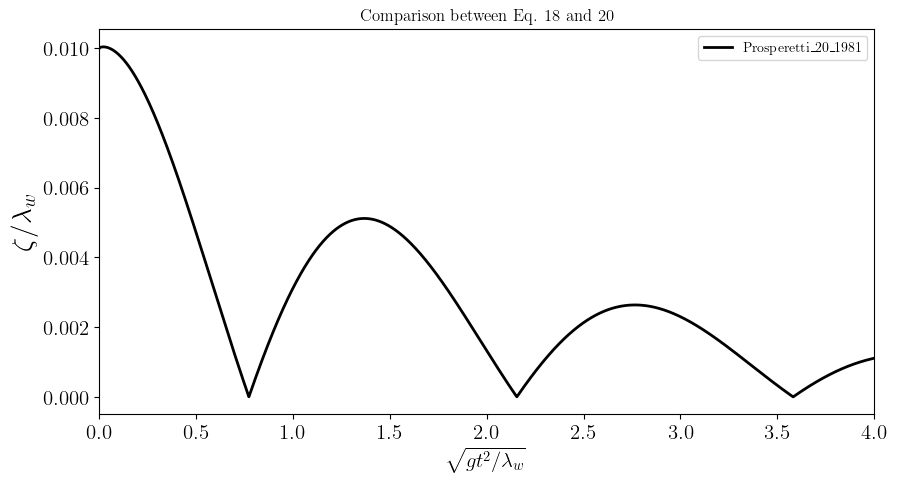

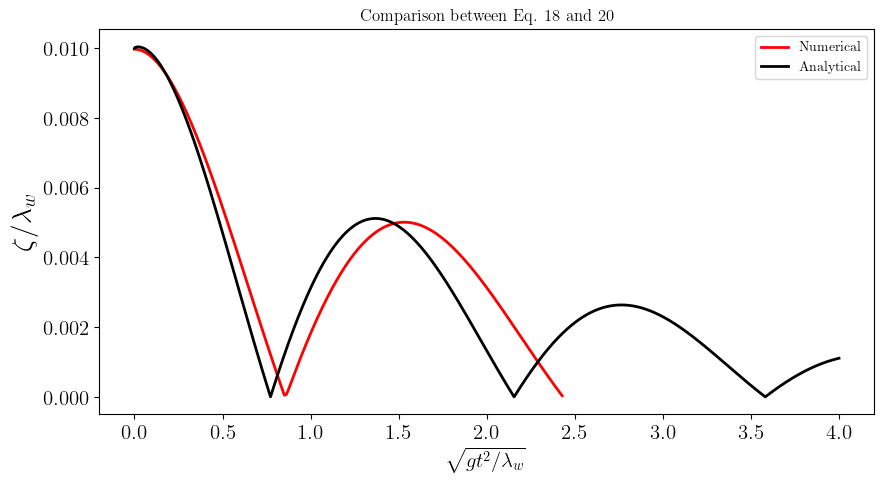

In [46]:
#Reads data from a file and separates columns into variables of time and Amplitude
def read_extract(dat_file):
    df = pd.read_csv(dat_file, sep=' ')
    df.head()
    nb_col = len(df.columns)
    
    if (nb_col==2):
        t = df.iloc[:, 0].to_numpy()
        Amp = df.iloc[:, 1].to_numpy()
        A0 = Amp[0]
        return A0, t, Amp
    
    else :
        t = df.iloc[:, 0].to_numpy()
        AmpOcean = df.iloc[:, 1].to_numpy()
        AmpIce = df.iloc[:, 2].to_numpy()
        A0_Ocean = AmpOcean[0]
        A0_Ice = AmpIce[0]
        return A0_Ocean, A0_Ice, t, AmpOcean, AmpIce
        
#Import data from Waterwaves.c and gravity.c
A0, t, Amp = read_extract('WavesWater_/amplitude.dat')

#Set plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))
#ax.plot(t1, abs(A1), 'r-', lw=2, label='Prosperetti_18_1976')
ax.plot(t2, abs(A2), 'k-', lw=2, label='Prosperetti_20_1981')
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=15)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 4])
#ax.set_ylim([0., A0])
ax.legend()
plt.title("Comparison between Eq. 18 and 20")
#plt.savefig("Comparison_pa_Ga=150004")
plt.show()

#Set plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(t, abs(Amp), 'r-', lw=2, label='Numerical')
ax.plot(t2, abs(A2), 'k-', lw=2, label='Analytical')
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=15)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlim([0., 4])
#ax.set_ylim([0., A0])
ax.legend()
plt.title("Comparison between Eq. 18 and 20")
#plt.savefig("Comparison_pa_Ga=150004")
plt.show()

# Annex

### Simple IODE

In [ ]:
##Test integro-diff solver with simple integro-diff eq 
#relevant packages 
from scipy.integrate import odeint
from scipy.integrate import quadrature
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import time

# Start measuring the execution time
start_time = time.time()

#Define ODE function without and with integral
def model0(a,t):
    dadt = 1.0 - 2.0 * a
    return dadt

def model(t, a, guess):
    interpolator = interp1d(guess[:,0], guess[:,1], kind='linear')
    y, _ = quadrature(lambda s: interpolator(s), 0, t, tol=1e-10, rtol=1e-8, maxiter=1500)
    dadt = 1.0 - 2.0 * a - 5.0 * y
    return dadt


#Calculate the simple diff eq solution
t = np.linspace(0, 10, 100)
a0 = 0
sol0 = odeint(model0, a0, t)

#Parameters for getting precise solution to ODE
counter = 1 
err = 1e4 
Tol = 1e-8
guess_data = np.column_stack((t, sol0))
t_span = (t[0], t[-1])

#Solves the integro diff eq until the solution is precise enough
while err > Tol:
    sol = solve_ivp(model, t_span, [a0], args=(guess_data,), t_eval=t, method='RK45')
    err = sum((sol.y[0]-guess_data[:,1])**2)
    print(f'{counter:4d}: {err:8.2e}')
    wt = 0.5
    guess_data = np.column_stack((t, (1-wt)*guess_data[:,1] + wt*sol.y[0]))
    counter = counter+1

# Plot the solution
plt.plot(t, sol.y[0])
plt.show()

#Execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")